***
# Base Bi-LSTM Model using only 136k training and 40k of val of the original data of 90% training<br>
***

***
## 1 Load the train/val/test/balanced test datasets
emotions_with_neutrals_220228.csv concatenated the neutrals from Kaggle dataset<br>
https://github.com/dair-ai/emotion_dataset<br>
https://huggingface.co/datasets/dair-ai/emotion<br>

In [74]:
import pandas as pd
import numpy as np

# mount google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
# read from the google drive
project_folder = '/content/gdrive/MyDrive/266_Final_Project_Folder'

version = '_kaggle'

test_source = project_folder + '/datasets/kaggle_data_no_dupe.csv'

# Load the dfs
test_df = pd.read_csv(test_source)

# drop the tweet_id column
test_df.drop(columns=test_df.columns[0], axis=1, inplace=True)

In [76]:
test_df

emotions                                               text
0      sadness  Layin n bed with a headache  ughhhh...waitin o...
1      sadness                Funeral ceremony...gloomy friday...
2      neutral  @dannycastillo We want to trade with someone w...
3      sadness  I should be sleep, but im not! thinking about ...
4      sadness            @charviray Charlene my love. I miss you
...        ...                                                ...
19774  neutral  @sendsome2me haha, yeah. Twitter has many uses...
19775  neutral                                   @JohnLloydTaylor
19776     love                     Happy Mothers Day  All my love
19777     love  Happy Mother's Day to all the mommies out ther...
19778     love  @mopedronin bullet train from tokyo    the gf ...

[19779 rows x 2 columns]

***
## 2 Tokenizer

### Find the top word count (frequency > 10)
We'll use this number as our vocabulary size

In [77]:
# Split the text column into a list of words
words_df = test_df['text'].str.split().to_frame('words')

# Explode the list of words into separate rows
words_df = words_df.explode('words')

# Group by the words and count their occurrences
words_df = words_df.groupby('words').size().reset_index(name='count')
words_df

words  count
0             !    149
1            !!     38
2           !!!     29
3          !!!!      7
4         !!!!!      5
...         ...    ...
48489   ï¿½why?      1
48490    ï¿½you      1
48491    ï¿½ï¿½      3
48492  ï¿½ï¿½We      1
48493  ï¿½ï¿½h.      1

[48494 rows x 2 columns]

In [78]:
# find the words with 'count' > 10
condition = words_df['count'] > 10

# sort the words based on count
new_words_df = words_df[condition].sort_values('count', ascending=False)
new_words_df

words  count
45187        to   6591
16295         I   6001
44667       the   5759
22739         a   4210
37622        my   3372
...         ...    ...
13951      DAY!     11
30854     fully     11
30762  friends,     11
46408       us.     11
30350      flat     11

[1960 rows x 2 columns]

In [90]:
# how many words are > 10?
top_word_count = len(new_words_df)
print('Vocabulary size:', top_word_count)

Vocabulary size: 1960


### Let's tokenize the train tweets!

In [89]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [88]:
tokenizer = Tokenizer(num_words=top_word_count, oov_token='<UNK>')
tokenizer.fit_on_texts(test_df['text']) # pass in tweets from training set

In [87]:
# this is what the tweet looks like as words
test_df['text'][0]

'Layin n bed with a headache  ughhhh...waitin on your call...'

In [86]:
# this is what the tokenized version of the tweet looks like
tokenizer.texts_to_sequences([test_df['text'][0]])

[[1, 263, 154, 23, 5, 526, 1, 1, 15, 41, 292]]

(array([1.210e+03, 3.011e+03, 3.361e+03, 1.909e+03, 2.574e+03, 2.139e+03,
        1.229e+03, 1.701e+03, 1.463e+03, 8.890e+02, 2.050e+02, 8.100e+01,
        5.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([  1.        ,   3.7027027 ,   6.40540541,   9.10810811,
         11.81081081,  14.51351351,  17.21621622,  19.91891892,
         22.62162162,  25.32432432,  28.02702703,  30.72972973,
         33.43243243,  36.13513514,  38.83783784,  41.54054054,
         44.24324324,  46.94594595,  49.64864865,  52.35135135,
         55.05405405,  57.75675676,  60.45945946,  63.16216216,
         65.86486486,  68.56756757,  71.27027027,  73.97297297,
         76.67567568,  79.37837838,  82.08108108,  84.78378378,
         87.48648649,  

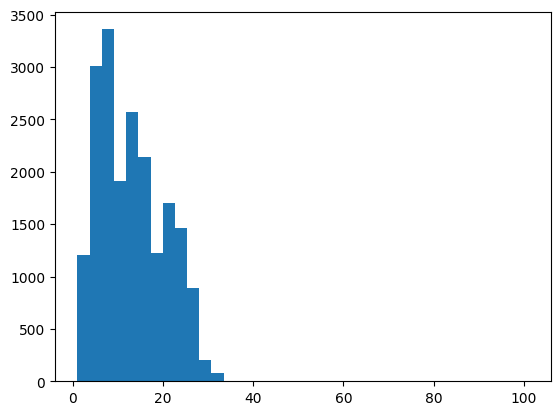

In [85]:
import matplotlib.pyplot as plt

# check to see what lenghts of the tweets in the dataset
lengths = [len(t.split(' ')) for t in test_df['text']]
plt.hist(lengths, bins=len(set(lengths)))

In [91]:
import statistics

# Apply the lambda function to the 'content' column and list called word_count_list'
word_count_list = list(test_df['text'].apply(lambda x: len(x.split(' '))))

# display the maximum and minimum lengths
print('Maximum word count:', max(word_count_list))
print('Minimum word count:', min(word_count_list))
print('Mean word count:', statistics.mean(word_count_list))
print('Median word count:', statistics.median(word_count_list))
print('75th percentile word count:', np.percentile(word_count_list, 75))
print('85th percentile word count:', np.percentile(word_count_list, 85))
print('95th percentile word count:', np.percentile(word_count_list, 95))

Maximum word count: 101
Minimum word count: 1
Mean word count: 13.09110672935942
Median word count: 12
75th percentile word count: 19.0
85th percentile word count: 22.0
95th percentile word count: 26.0


The max number of words is 101. We ultimately decided that we are going to keep all the words in the tweet. BERT can handle more than 200 so setting max_len = 200

***
## 3 Padding and truncating the training data sequences to make sure that the shape is the same for each string.

In [92]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [93]:
max_len = 200 # set the largest tweet size, >200 words -> truncate, <200 words -> pad

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len) # truncating happens at the end of the sequence (post)
  return padded # all examples will be the returned with same input size

In [ ]:
# padded_train_seq = get_sequences(tokenizer, train_df['text'])
# padded_train_seq[0]

***
## 4 Convert labels to numeric

### Function to convert text labels to numeric (reuse for all datasets)

In [94]:
# keeping this consistent for all models
class_to_index_dict = {'sadness': 0, 'anger': 1, 'fear': 2, 'surprise': 3, 'joy': 4, 'love': 5, 'neutral': 6}
# ['sadness', 'anger', 'love', 'surprise', 'neutral']
# class_to_index_dict = {'sadness': 0, 'anger': 1, 'surprise': 3, 'love': 5, 'neutral': 6}
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [95]:
def names_to_ids(class_to_index, data):
  return np.array([class_to_index.get(x) for x in data])

In [96]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
test_labels = names_to_ids(class_to_index_dict, test_df['emotions'])
print('train_df.iloc[7]:\n', test_df.iloc[index])
print('numeric label:', test_labels[index])

train_df.iloc[7]:
 emotions                                              sadness
text        Ugh! I have to beat this stupid song to get to...
Name: 7, dtype: object
numeric label: 0


***
## 5 Create the model

In [97]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import random

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


In [98]:
# ref: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/
# ref: https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/
# ref: https://stackoverflow.com/questions/40331510/how-to-stack-multiple-lstm-in-keras

# keep the vocabulary size the same as the base model, 11039
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=11039, output_dim=8, input_length=max_len),
    
    # the RNN part of the model
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)), # since using an LSTM layer inside a bidrectional layer, context can go in either direction; return_sequences=True means at every time step, there is an output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, )),

    tf.keras.layers.Dense(7, activation='softmax') # 7 for the seven classes

])

model.compile(
    loss='sparse_categorical_crossentropy', # since this is a multiclass classification problem, use categorical crossentropy; since classes are integers (not one hot encoded/binary), use sparse (just like in A3)
    optimizer='adam',
    metrics=['accuracy']
)

In [99]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 8)            88312     
                                                                 
 bidirectional_5 (Bidirectio  (None, 20)               1520      
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 7)                 147       
                                                                 
Total params: 89,979
Trainable params: 89,979
Non-trainable params: 0
_________________________________________________________________


### From Natalie's Notebook
https://github.com/datasci-w266/2023-spring-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb<br><br>
https://edstem.org/us/courses/32607/discussion/2699088?comment=6229916

#### Inspired by Natalie's notebook, made my own generator that chunks up my data into pieces that won't make my machine run out of memory before completing one epoch
If generator is not used, might delete this section

### Training the Model!!!

##### Uncomment cell below to load checkpoints; else keep commented to start fresh

In [100]:
# uncomment below when loading checkpoints
checkpoint_dir = project_folder + '/cm_working_dir/cm_checkpoints/base_model'
hdf5_checkpoint = 'weights.05-0.98' # change this to the right filename for the checkpoint
checkpoint_filepath = checkpoint_dir + '/' + hdf5_checkpoint + '.hdf5'
model.load_weights(checkpoint_filepath)

In [ ]:
# batch_size = 64
# steps_per_epoch = len(padded_train_seq) / batch_size

# history = model.fit(
#     gen,
#     validation_data=(val_seq, val_labels),
#     steps_per_epoch=steps_per_epoch,
#     epochs=1,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
#         model_checkpoint_callback
#     ]
# )

# uncomment below when loading checkpoints

##### Training a fresh model (don't run this if running cells above)

In [ ]:
# batch_size = 64
# steps_per_epoch = len(padded_train_seq) / batch_size

# history = model.fit(
#     # gen,
#     padded_train_seq,
#     train_labels,
#     validation_data=(val_seq, val_labels),
#     steps_per_epoch=steps_per_epoch,
#     epochs=5,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
#         model_checkpoint_callback
#     ]
# )

In [ ]:
# show_history(history)

***
## 7 Evaluate the model using imbalanced test_df

In [101]:
# borrowing this from A3 assignment, but turned it into a function
# classification report (cr) and confusion matrix (cm) from A3
from sklearn.metrics import classification_report
import seaborn as sns

def make_cr_cm(preds, labels):

  predictions_model = tf.argmax(preds, axis=-1)
  predictions_model

  # convert labels to string because classification_report needs target_names as str
  # labels are currently ints, but will change to str of in (i.e. '0', '1', etc)
  # class_names = list(set([str(digit) for digit in labels]))

  class_names = ['0', '1', '2', '3', '4', '5', '6']

  # convert digits in target_names to the actual name of the emotion from the 
  # using class_to_index dictionary (i.e. '0' -> 'love', '5' -> 'neutral', etc.)
  class_names = [list(class_to_index_dict.keys())[list(class_to_index_dict.values()).index(int(name))] for name in class_names]

  print('Classification Report:\n\n', classification_report(labels, predictions_model.numpy(), target_names=class_names))

  print('Confusion Matrix:\n')
  
  # confusion matrix from A3
  cm = tf.math.confusion_matrix(labels, predictions_model)
  cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

  plt.figure(figsize=(20,7))
  sns.heatmap(
      cm, annot=True,
      xticklabels=class_names,
      yticklabels=class_names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.show()

### Padding the imbalanced test set for evaluation

In [102]:
padded_test_seq = get_sequences(tokenizer, test_df['text'])
padded_test_seq[0]

array([  1, 263, 154,  23,   5, 526,   1,   1,  15,  41, 292,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [103]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [104]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
test_labels = names_to_ids(class_to_index_dict, test_df['emotions'])
print('test_df.iloc[7]:\n', test_df.iloc[index])
print('numeric label:', test_labels[index])

test_df.iloc[7]:
 emotions                                              sadness
text        Ugh! I have to beat this stupid song to get to...
Name: 7, dtype: object
numeric label: 0


### Evaluating the model using test_df!!!

In [105]:
model.evaluate(padded_test_seq, test_labels)

619/619 [==============================] - 6s 7ms/step - loss: 4.2314 - accuracy: 0.3153


[4.231433391571045, 0.3152838945388794]

In [106]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_df.iloc[i])
print('Emotion:', test_labels[i])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: emotions                                        neutral
text        Tonight is the last Jay Leno late nigt show
Name: 6449, dtype: object
Emotion: 6
1/1 [==============================] - 1s 606ms/step
Predicted Emotion: 6


In [107]:
preds_imbalanced_test_set = model.predict(padded_test_seq)

619/619 [==============================] - 4s 6ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:

               precision    recall  f1-score   support

     sadness       0.29      0.14      0.19      5142
       anger       0.00      0.05      0.01       110
        fear       0.00      0.00      0.00         0
    surprise       0.05      0.00      0.00      2177
         joy       0.00      0.00      0.00         0
        love       0.23      0.01      0.02      3770
     neutral       0.47      0.64      0.54      8580

    accuracy                           0.32     19779
   macro avg       0.15      0.12      0.11     19779
weighted avg       0.33      0.32      0.29     19779

Confusion Matrix:



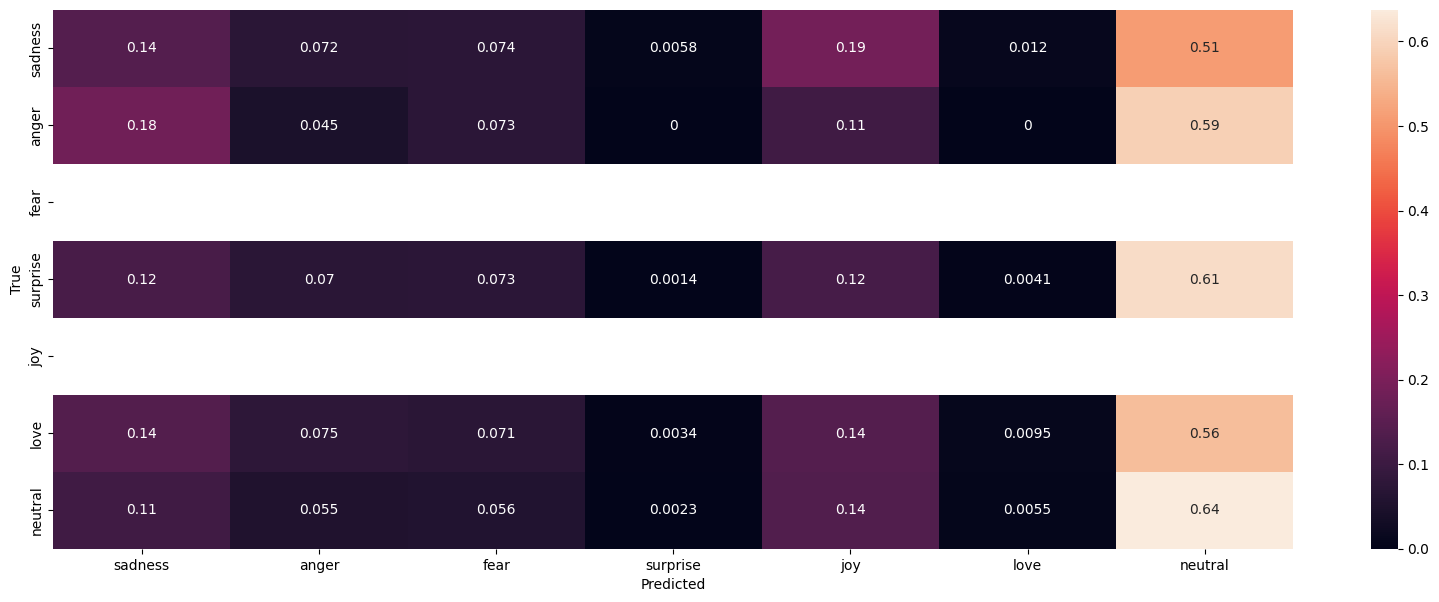

In [108]:
make_cr_cm(preds_imbalanced_test_set, test_labels)

***
## 8 Evaluating the model again, but with balanced_test_df!!!

### Padding the balanced test set for evaluation

In [73]:
padded_balanced_test_seq = get_sequences(tokenizer, balanced_test_df['text'])
padded_balanced_test_seq[0]

NameError: ignored

In [ ]:
# reminder of the class_to_index mapping
class_to_index_dict

{'sadness': 0,
 'anger': 1,
 'fear': 2,
 'surprise': 3,
 'joy': 4,
 'love': 5,
 'neutral': 6}

In [ ]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
balanced_test_labels = names_to_ids(class_to_index_dict, balanced_test_df['emotions'])
print('balanced_test_df.iloc[7]:\n', balanced_test_df.iloc[index])
print('numeric label:', balanced_test_labels[index])

balanced_test_df.iloc[7]:
 text        i feel like i m wronged
emotions                      anger
Name: 7, dtype: object
numeric label: 1


### Evaluating the model using balanced_test_df!!!

In [ ]:
model.evaluate(padded_balanced_test_seq, balanced_test_labels)

189/189 [==============================] - 1s 7ms/step - loss: 0.1652 - accuracy: 0.9570


[0.1652338206768036, 0.9569767713546753]

In [ ]:
# printing out a random tweet and its label, then calling
# model.predict to see what the model predicts
i = random.randint(0, len(balanced_test_labels) - 1)

print('Sentence:', balanced_test_df.iloc[i])
print('Emotion:', balanced_test_labels[i])

p = model.predict(np.expand_dims(padded_balanced_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        im happy to say that i was productive this wee...
emotions                                                 fear
Name: 1638, dtype: object
Emotion: 2
1/1 [==============================] - 0s 25ms/step
Predicted Emotion: 2


In [ ]:
preds_balanced_test_set = model.predict(padded_balanced_test_seq)

189/189 [==============================] - 1s 6ms/step


Classification Report:

               precision    recall  f1-score   support

        love       0.94      0.98      0.96       860
         joy       0.93      0.96      0.95       860
     neutral       0.97      0.96      0.96       860
        fear       0.98      0.92      0.95       860
     sadness       0.95      0.97      0.96       860
       anger       0.96      0.95      0.96       860
    surprise       0.98      0.95      0.97       860

    accuracy                           0.96      6020
   macro avg       0.96      0.96      0.96      6020
weighted avg       0.96      0.96      0.96      6020

Confusion Matrix:



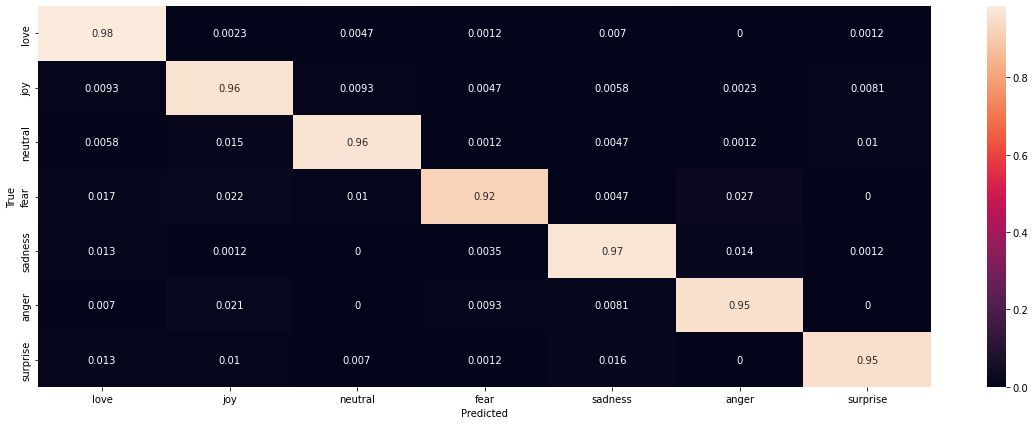

In [ ]:
make_cr_cm(preds_balanced_test_set, balanced_test_labels)